In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_curve, auc, roc_auc_score, 
                             accuracy_score, precision_score, recall_score, f1_score)
sns.set_style('whitegrid')
sns.set_palette('Set2')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [7]:
df = pd.read_csv('../data/smart_logistics_dataset.csv')

print(f"데이터: {df.shape}")
print(df.head())
print(df.columns.tolist())

print("\n데이터 타입:")
print(df.dtypes)

print("\n결측값:")
print(df.isnull().sum())

print("\n기초 통계:")
print(df.describe())

print("\n데이터셋 정보:")
print(df.info())

데이터: (1000, 16)
             Timestamp  Asset_ID  Latitude  Longitude  Inventory_Level  \
0  2024-03-20 00:11:14   Truck_7  -65.7383    11.2497              390   
1  2024-10-30 07:53:51   Truck_6   22.2748  -131.7086              491   
2  2024-07-29 18:42:48  Truck_10   54.9232    79.5455              190   
3  2024-10-28 00:50:54   Truck_9   42.3900    -1.4788              330   
4  2024-09-27 15:52:58   Truck_7  -65.8477    47.9468              480   

  Shipment_Status  Temperature  Humidity Traffic_Status  Waiting_Time  \
0         Delayed         27.0      67.8         Detour            38   
1      In Transit         22.5      54.3          Heavy            16   
2      In Transit         25.2      62.2         Detour            34   
3       Delivered         25.4      52.3          Heavy            37   
4         Delayed         20.5      57.2          Clear            56   

   User_Transaction_Amount  User_Purchase_Frequency Logistics_Delay_Reason  \
0                     

### 데이터 전처리 & 특성

In [8]:


df_processed = df.copy()

# 결측값 처리
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print(f"정제 후: {len(df_processed):,}건")

정제 후: 1,000건


### EDA(탐색적 데이터 분석)

In [9]:
print("\n=== 수치형 컬럼")
numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
print(f"수치형 컬럼 ({len(numeric_columns)}개): {list(numeric_columns)}")

print("\n=== 범주형 컬럼")
categorical_columns = df_processed.select_dtypes(include=['object']).columns
print(f"범주형 컬럼 ({len(categorical_columns)}개): {list(categorical_columns)}")

for col in categorical_columns:
    print(f"\n{col} - 고유값: {df_processed[col].nunique()}")
    print(df_processed[col].value_counts().head())



=== 수치형 컬럼
수치형 컬럼 (11개): ['Latitude', 'Longitude', 'Inventory_Level', 'Temperature', 'Humidity', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Asset_Utilization', 'Demand_Forecast', 'Logistics_Delay']

=== 범주형 컬럼
범주형 컬럼 (5개): ['Timestamp', 'Asset_ID', 'Shipment_Status', 'Traffic_Status', 'Logistics_Delay_Reason']

Timestamp - 고유값: 1000
Timestamp
2024-03-20 00:11:14    1
2024-10-30 07:53:51    1
2024-07-29 18:42:48    1
2024-10-28 00:50:54    1
2024-09-27 15:52:58    1
Name: count, dtype: int64

Asset_ID - 고유값: 10
Asset_ID
Truck_8     109
Truck_4     107
Truck_2     105
Truck_10    105
Truck_6     103
Name: count, dtype: int64

Shipment_Status - 고유값: 3
Shipment_Status
Delayed       350
Delivered     338
In Transit    312
Name: count, dtype: int64

Traffic_Status - 고유값: 3
Traffic_Status
Detour    345
Clear     328
Heavy     327
Name: count, dtype: int64

Logistics_Delay_Reason - 고유값: 3
Logistics_Delay_Reason
Weather               530
Traffic               236
Me

### 범주형 변수 인코딩 & 특성

  Shipment_Status: ['Delayed' 'In Transit' 'Delivered']
  Traffic_Status: ['Detour' 'Heavy' 'Clear']
----------------------------------------------------------------------
저장: ../output/01_eda_analysis.png


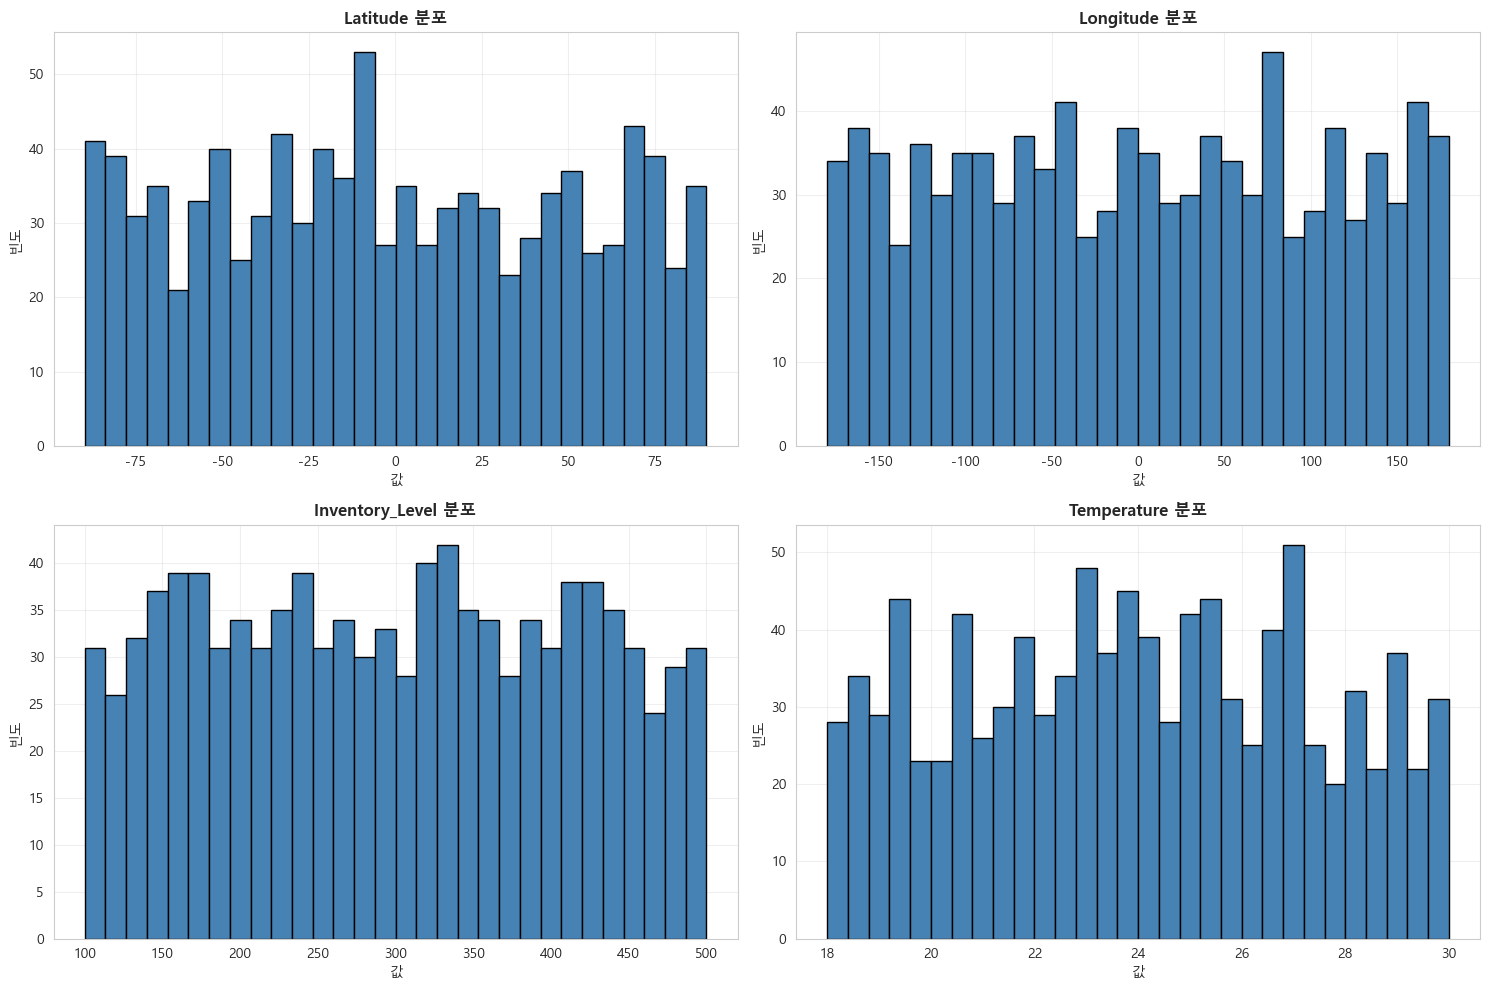

In [10]:
df_processed['Shipment_Status_encoded'] = pd.factorize(df_processed['Shipment_Status'])[0]
df_processed['Traffic_Status_encoded'] = pd.factorize(df_processed['Traffic_Status'])[0]

print(f"  Shipment_Status: {df_processed['Shipment_Status'].unique()}")
print(f"  Traffic_Status: {df_processed['Traffic_Status'].unique()}")
print("-" * 70)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 상위 4개 수치형 컬럼의 히스토그램
numeric_list = list(numeric_columns[:4])

for idx, col in enumerate(numeric_list):
    ax = axes[idx // 2, idx % 2]
    df_processed[col].hist(bins=30, ax=ax, color='steelblue', edgecolor='black')
    ax.set_title(f'{col} 분포', fontsize=12, fontweight='bold')
    ax.set_xlabel('값')
    ax.set_ylabel('빈도')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/01_eda_analysis.png', dpi=300, bbox_inches='tight')
print("저장: ../output/01_eda_analysis.png")
plt.show()

### 특성 선택 및 타겟 변수 확인

In [11]:
# 수치형 특성 & 인코딩된 범주형 특성
feature_cols = ['Latitude', 'Longitude', 'Inventory_Level', 'Temperature', 
                'Humidity', 'Waiting_Time', 'User_Transaction_Amount', 
                'User_Purchase_Frequency', 'Asset_Utilization', 'Demand_Forecast',
                'Traffic_Status_encoded']

X = df_processed[feature_cols].copy()

# 타겟 변수: 데이터에 이미 있는 상태
y = df_processed['Logistics_Delay'].copy()

print(f"특성 수: {X.shape[1]}")
print(f"샘플 수: {len(X):,}")
print(f"특성명: {feature_cols}")
print(f"\n타겟 변수 분포:")
print(f"  지연 없음 (0): {(y == 0).sum():,}건 ({(y == 0).sum()/len(y)*100:.1f}%)")
print(f"  지연 있음 (1): {(y == 1).sum():,}건 ({(y == 1).sum()/len(y)*100:.1f}%)")

# 상관관계 분석
correlation = pd.DataFrame({
    'feature': feature_cols,
    'correlation': [X[col].corr(y) for col in feature_cols]
}).sort_values('correlation', key=abs, ascending=False)
print(correlation)


특성 수: 11
샘플 수: 1,000
특성명: ['Latitude', 'Longitude', 'Inventory_Level', 'Temperature', 'Humidity', 'Waiting_Time', 'User_Transaction_Amount', 'User_Purchase_Frequency', 'Asset_Utilization', 'Demand_Forecast', 'Traffic_Status_encoded']

타겟 변수 분포:
  지연 없음 (0): 434건 (43.4%)
  지연 있음 (1): 566건 (56.6%)
                    feature  correlation
5              Waiting_Time    -0.063036
0                  Latitude     0.039634
3               Temperature    -0.038067
9           Demand_Forecast    -0.018621
7   User_Purchase_Frequency    -0.017439
6   User_Transaction_Amount     0.013605
1                 Longitude     0.011796
2           Inventory_Level    -0.003340
8         Asset_Utilization    -0.003140
10   Traffic_Status_encoded     0.001530
4                  Humidity    -0.000504


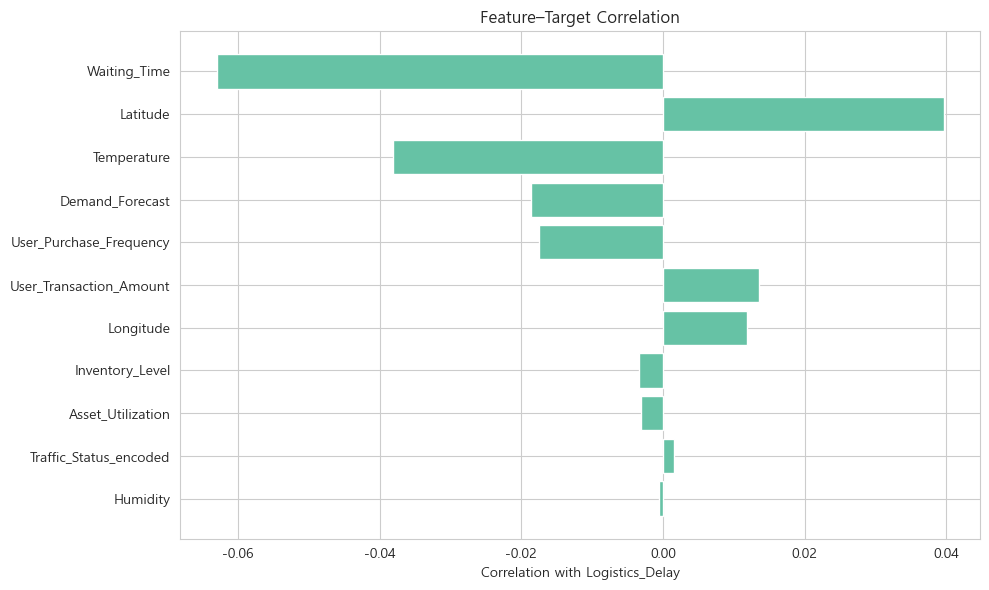

In [12]:
plt.figure(figsize=(10, 6))
plt.barh(correlation['feature'], correlation['correlation'])
plt.title('Feature–Target Correlation')
plt.xlabel('Correlation with Logistics_Delay')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

### 데이터 분할 & 표준화

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"훈련 데이터: {len(X_train):,}건")
print(f"  - 정상 (0): {(y_train==0).sum():,}, 지연 (1): {(y_train==1).sum():,}")
print(f"테스트 데이터: {len(X_test):,}건")
print(f"  - 정상 (0): {(y_test==0).sum():,}, 지연 (1): {(y_test==1).sum():,}")

# 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n표준화 확인:")
print(f"  표준화 전: mean={X_train.mean().mean():.3f}, std={X_train.std().mean():.3f}")
print(f"  표준화 후: mean={X_train_scaled.mean():.6f}, std={X_train_scaled.std():.3f}")


훈련 데이터: 700건
  - 정상 (0): 304, 지연 (1): 396
테스트 데이터: 300건
  - 정상 (0): 130, 지연 (1): 170

표준화 확인:
  표준화 전: mean=91.761, std=44.524
  표준화 후: mean=-0.000000, std=1.000


### Logistic Regression 모델링

In [14]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Logistic Regression 성과:")
print(f"  정확도: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"  정밀도: {precision_score(y_test, y_pred_lr):.4f}")
print(f"  재현율: {recall_score(y_test, y_pred_lr):.4f}")

Logistic Regression 성과:
  정확도: 0.5000
  ROC-AUC: 0.4505
  정밀도: 0.5424
  재현율: 0.7529


###  Random Forest 모델링

In [15]:

rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, 
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print(f"Random Forest:")
print(f"  정확도: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"  정밀도: {precision_score(y_test, y_pred_rf):.4f}")
print(f"  재현율: {recall_score(y_test, y_pred_rf):.4f}")

feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_rf.head(10))

Random Forest:
  정확도: 0.7267
  ROC-AUC: 0.7967
  정밀도: 0.7973
  재현율: 0.6941
                    feature  importance
10   Traffic_Status_encoded    0.269129
0                  Latitude    0.082129
2           Inventory_Level    0.079996
1                 Longitude    0.078222
8         Asset_Utilization    0.077154
9           Demand_Forecast    0.076138
3               Temperature    0.074628
6   User_Transaction_Amount    0.073818
4                  Humidity    0.073523
5              Waiting_Time    0.071188


### XGBoost 모델링

In [16]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=6, 
                         learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

print(f"XGBoost 성과:")
print(f"  정확도: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"  정밀도: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"  재현율: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"  F1-점수: {f1_score(y_test, y_pred_xgb):.4f}")

feature_importance_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n중요한 특성 Top 10:")
print(feature_importance_xgb.head(10))

XGBoost 성과:
  정확도: 0.7400
  ROC-AUC: 0.8099
  정밀도: 0.8108
  재현율: 0.7059
  F1-점수: 0.7547

중요한 특성 Top 10:
                    feature  importance
10   Traffic_Status_encoded    0.571600
8         Asset_Utilization    0.048070
4                  Humidity    0.048020
3               Temperature    0.047915
2           Inventory_Level    0.044359
1                 Longitude    0.043158
6   User_Transaction_Amount    0.041234
7   User_Purchase_Frequency    0.040429
9           Demand_Forecast    0.039676
5              Waiting_Time    0.039432


### 모델 비교

=== 모델 비교 ===
                 Model  Accuracy  ROC-AUC  Precision  Recall
0  Logistic Regression    0.5000   0.4505     0.5424  0.7529
1        Random Forest    0.7267   0.7967     0.7973  0.6941
2              XGBoost    0.7400   0.8099     0.8108  0.7059

최종 선택 모델: XGBoost (ROC-AUC: 0.8099)
저장: ../output/02_model_comparison.png


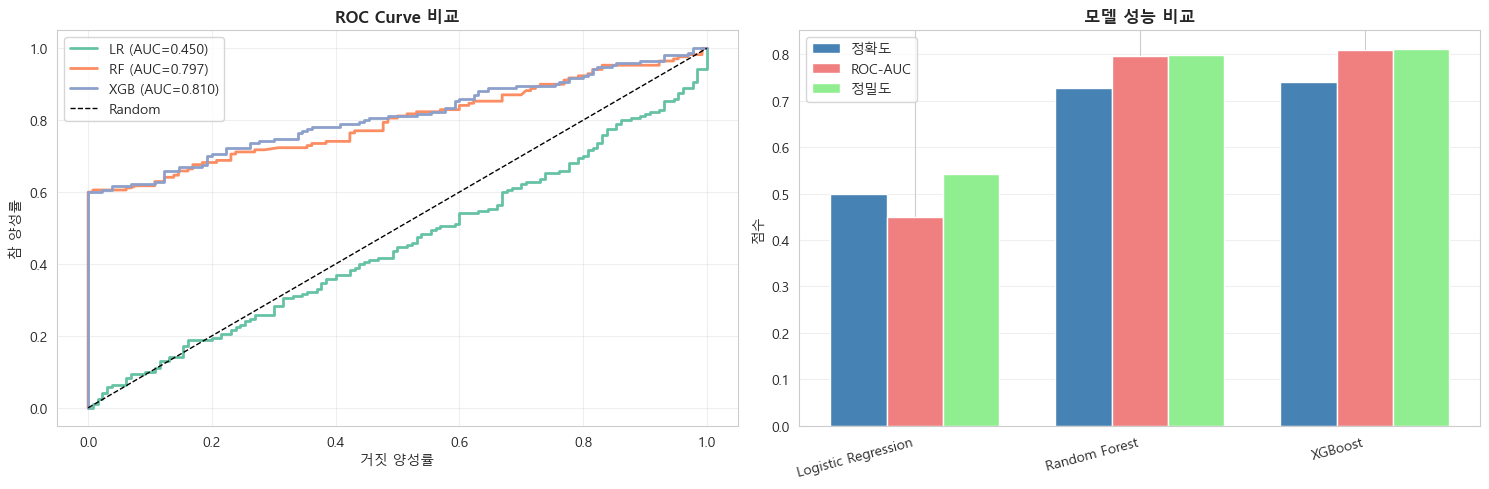

In [17]:

models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 
              'Random Forest', 
              'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)
    ]
}).round(4)

print("=== 모델 비교 ===")
print(models_comparison)
print(f"\n최종 선택 모델: XGBoost (ROC-AUC: {models_comparison.iloc[2]['ROC-AUC']:.4f})")

# ROC Curve 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC Curve 비교
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

axes[0].plot(fpr_lr, tpr_lr, label=f'LR (AUC={roc_auc_score(y_test, y_pred_proba_lr):.3f})', linewidth=2)
axes[0].plot(fpr_rf, tpr_rf, label=f'RF (AUC={roc_auc_score(y_test, y_pred_proba_rf):.3f})', linewidth=2)
axes[0].plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC={roc_auc_score(y_test, y_pred_proba_xgb):.3f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[0].set_xlabel('거짓 양성률')
axes[0].set_ylabel('참 양성률')
axes[0].set_title('ROC Curve 비교', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 모델 성능 비교
x_pos = np.arange(len(models_comparison))
width = 0.25

axes[1].bar(x_pos - width, models_comparison['Accuracy'], width, label='정확도', color='steelblue')
axes[1].bar(x_pos, models_comparison['ROC-AUC'], width, label='ROC-AUC', color='lightcoral')
axes[1].bar(x_pos + width, models_comparison['Precision'], width, label='정밀도', color='lightgreen')

axes[1].set_ylabel('점수')
axes[1].set_title('모델 성능 비교', fontsize=12, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models_comparison['Model'], rotation=15, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../output/02_model_comparison.png', dpi=300, bbox_inches='tight')
print("저장: ../output/02_model_comparison.png")
plt.show()

### 특성 중요도 분석

저장: ../output/03_feature_importance.png


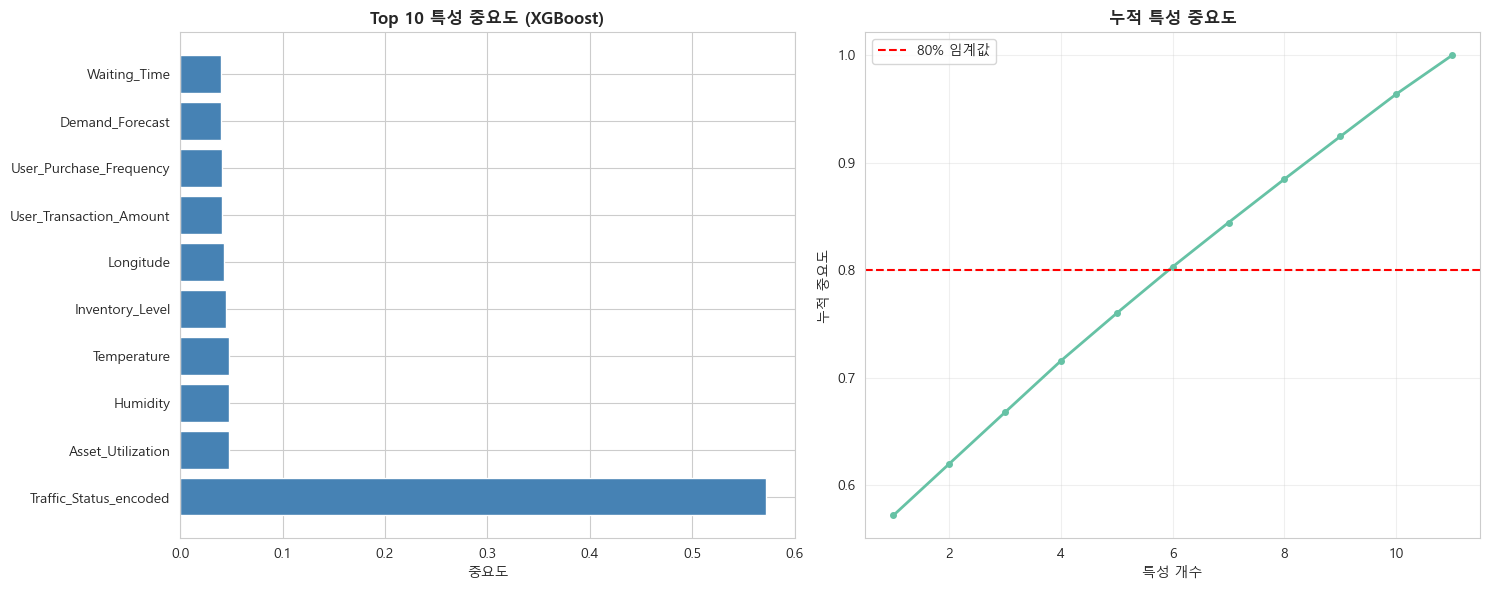


=== 지연 요인 분석 (Top 5) ===
11. Traffic_Status_encoded: 57.2%
9. Asset_Utilization: 4.8%
5. Humidity: 4.8%
4. Temperature: 4.8%
3. Inventory_Level: 4.4%


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top 10 특성 중요도
top_features = feature_importance_xgb.head(10)
axes[0].barh(top_features['feature'], top_features['importance'], color='steelblue')
axes[0].set_title('Top 10 특성 중요도 (XGBoost)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('중요도')

# 누적 기여도
cumsum = feature_importance_xgb['importance'].cumsum() / feature_importance_xgb['importance'].sum()
axes[1].plot(range(1, len(cumsum)+1), cumsum.values, marker='o', linewidth=2, markersize=4)
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% 임계값')
axes[1].set_xlabel('특성 개수')
axes[1].set_ylabel('누적 중요도')
axes[1].set_title('누적 특성 중요도', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/03_feature_importance.png', dpi=300, bbox_inches='tight')
print("저장: ../output/03_feature_importance.png")
plt.show()

# 지연 요인 분석
print("\n=== 지연 요인 분석 (Top 5) ===")
for idx, row in feature_importance_xgb.head(5).iterrows():
    print(f"{idx+1}. {row['feature']}: {row['importance']*100:.1f}%")

### summary & conclusion

In [22]:
# 예측 결과 저장하기
results_df = pd.DataFrame({
    'prediction': y_pred_xgb,
    'probability': y_pred_proba_xgb,
    'actual': y_test.values,
    'correct': (y_pred_xgb == y_test.values).astype(int)
})

results_df.to_csv('../output/predictions.csv', index=False)
print("저장: ../output/predictions.csv")
print(f"\n결과:")
print(results_df.head(10))

print("summary")
print("\n모델 성능")
print(f"  선택 모델: XGBoost")
print(f"  정확도: {accuracy_score(y_test, y_pred_xgb):.1%}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.3f}")
print(f"  정밀도: {precision_score(y_test, y_pred_xgb):.1%}")
print(f"  재현율: {recall_score(y_test, y_pred_xgb):.1%}")

print("\n지연 요인 분석 - Top 3")
for idx, (i, row) in enumerate(feature_importance_xgb.head(3).iterrows(), 1):
    print(f"  {idx}. {row['feature']}: {row['importance']*100:.1f}%")


저장: ../output/predictions.csv

결과:
   prediction  probability  actual  correct
0           1     0.985482       1        1
1           0     0.385824       1        0
2           1     0.979452       1        1
3           1     0.993871       1        1
4           0     0.335568       1        0
5           1     0.568350       1        1
6           1     0.992219       1        1
7           0     0.491132       1        0
8           0     0.201886       1        0
9           0     0.448260       0        1
summary

모델 성능
  선택 모델: XGBoost
  정확도: 74.0%
  ROC-AUC: 0.810
  정밀도: 81.1%
  재현율: 70.6%

지연 요인 분석 - Top 3
  1. Traffic_Status_encoded: 57.2%
  2. Asset_Utilization: 4.8%
  3. Humidity: 4.8%
